# Practical Time Series Analysis  - Forecasting Individual Household Electric Power Consumption

Explore and build time series forecasting models for measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years.

**Data Set Information**

Data Link: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

Notes:

1. (globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2. The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Attribute Information:**

- date: Date in format dd/mm/yyyy
- time: time in format hh:mm:ss
- globalactivepower: household global minute-averaged active power (in kilowatt)
- globalreactivepower: household global minute-averaged reactive power (in kilowatt)
- voltage: minute-averaged voltage (in volt)
- global_intensity: household global minute-averaged current intensity (in ampere)
- submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
- submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
- submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip', 
                 sep=";", infer_datetime_format=True,
                 parse_dates={'Datetime':[0,1]})
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
df.set_index('Datetime', inplace=True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.shape

(2075259, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [6]:
df.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [7]:
#number of missing values
df.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

Looking at the dataset table, most of the columns have numerical values, but they are stored in object datatype format. This is usually a clue to incorrect values.

In [8]:
#print out the unique values in each column to check for the incorrect value.
for col in df.columns:
    print(col)
    print(df[col].unique())
    print('******')

Global_active_power
['4.216' '5.360' '5.374' ... 4.0680000000000005 3.94 3.74]
******
Global_reactive_power
['0.418' '0.436' '0.498' '0.502' '0.528' '0.522' '0.520' '0.510' '0.470'
 '0.478' '0.398' '0.422' '0.282' '0.152' '0.156' '0.000' '0.076' '0.090'
 '0.200' '0.058' '0.180' '0.144' '0.118' '0.108' '0.202' '0.192' '0.186'
 '0.116' '0.136' '0.148' '0.160' '0.158' '0.100' '0.082' '0.050' '0.052'
 '0.162' '0.086' '0.048' '0.054' '0.068' '0.166' '0.174' '0.178' '0.188'
 '0.088' '0.080' '0.070' '0.084' '0.074' '0.106' '0.092' '0.064' '0.046'
 '0.138' '0.134' '0.132' '0.120' '0.130' '0.154' '0.078' '0.142' '0.140'
 '0.146' '0.150' '0.170' '0.102' '0.072' '0.060' '0.056' '0.062' '0.112'
 '0.066' '0.172' '0.168' '0.194' '0.184' '0.096' '0.164' '0.182' '0.094'
 '0.098' '0.176' '0.190' '0.204' '0.220' '0.198' '0.208' '0.244' '0.334'
 '0.298' '0.296' '0.286' '0.278' '0.104' '0.258' '0.238' '0.256' '0.214'
 '0.230' '0.210' '0.240' '0.124' '0.122' '0.270' '0.302' '0.272' '0.250'
 '0.294' '0.300'

Some columns (the columns with the wrong datatypes) have '?' in them. The '?' are the incorrect values that were suspected.

These are going to pose a problem because they are invalid values but they are not registered as missing values, a way to handle them is to convert them to missing values.

In [9]:
#how many '?' are in the columns
(df == '?').sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3               0
dtype: int64

There are 25979 '?' in each column, the exact number of missing values in *Sub_metering_3*

In [10]:
#make the '?' missing values
df.replace('?', np.nan, inplace=True)

In [11]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
df.isnull().sum() / df.shape[0]  * 100

Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64

There are 25979 missing entries in the dataframe; 1.251844% of the data is missing.

In [13]:
#convert the columns to the correct datatype (float)
df = df.astype(float)

In [14]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


Visualization

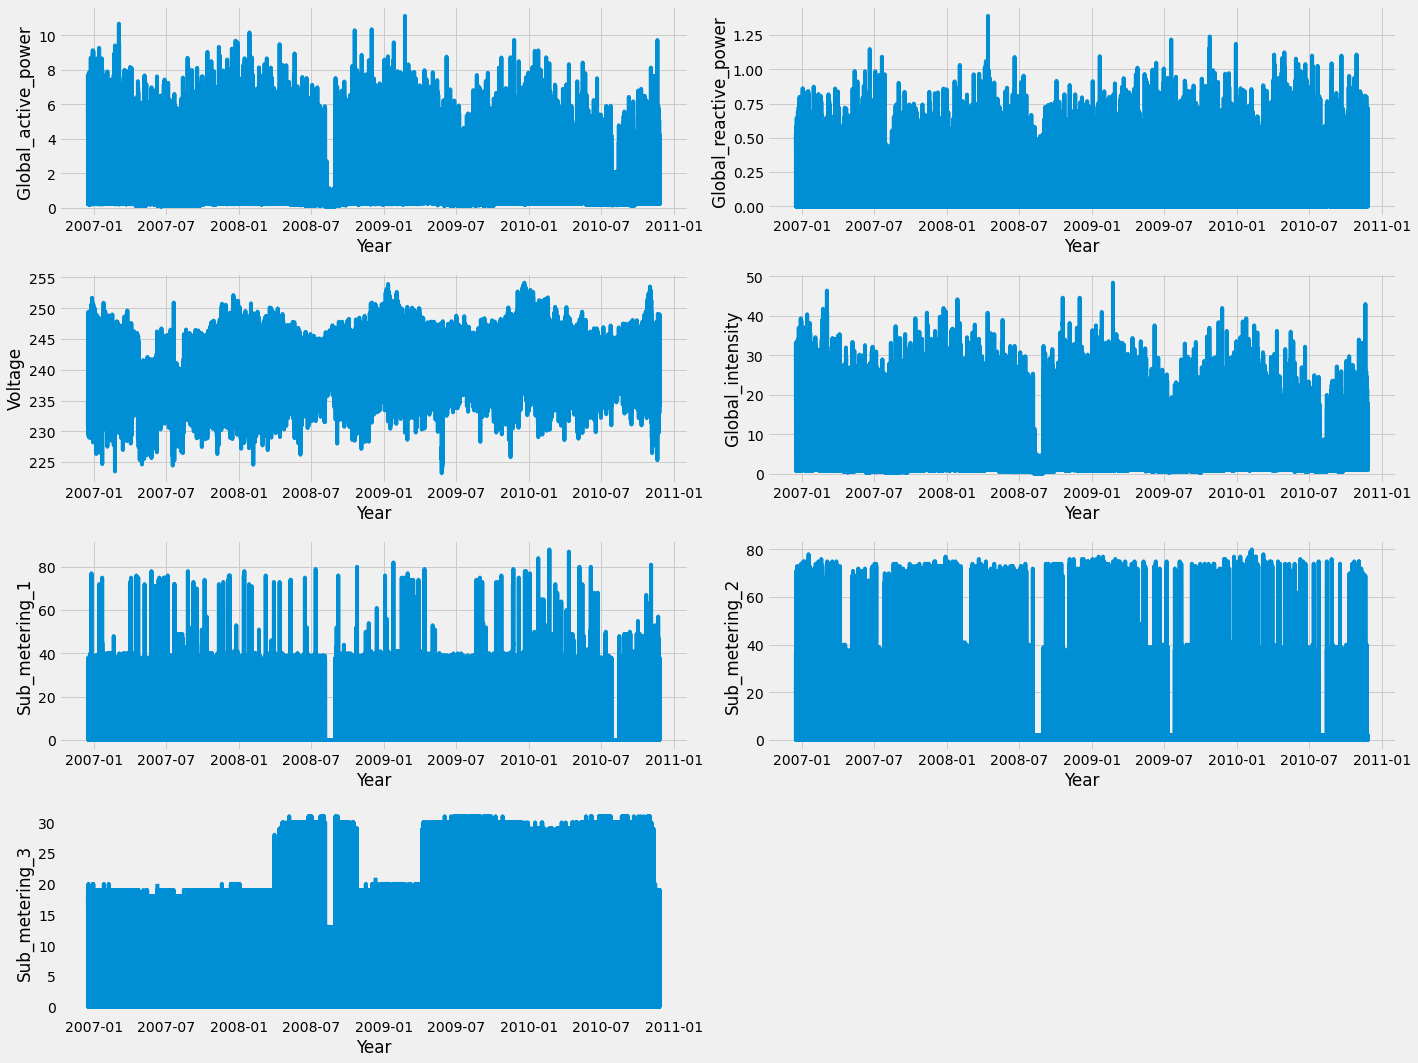

In [15]:
cols = df.columns

fig = plt.figure(figsize=(20, 15))
i = 0
for c in cols:
    a = fig.add_subplot(4, 2, i+1)
    
    plt.plot(df[c])
    plt.xlabel('Year')
    plt.ylabel(c)
    
    i+=1
    
plt.tight_layout()
plt.grid()

In [16]:
#create a copy of the data to continue working with
df_copy = df.copy()

Resample the data from a minute sampling rate to a daily sampling rate

In [17]:
df_daily = df_copy.resample('D').sum()

print('The data has been daownsampled to {} data points'.format(df_daily.shape[0]))

The data has been daownsampled to 1442 data points



Fill all the missing values with the mean (average) of their attribute/column.

In [18]:
for col in df_daily.columns:
    df_daily[col].fillna(df_daily[col].mean(), inplace=True)

In [19]:
#no missing values
df_daily.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [20]:
df_daily.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

Plot of daily global_active_power over time

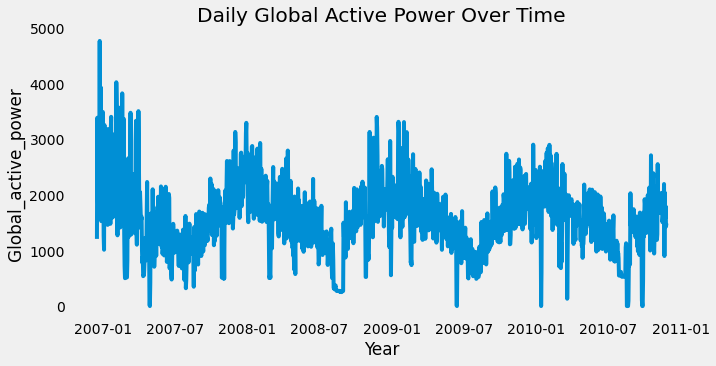

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(df_daily['Global_active_power'])
plt.xlabel('Year')
plt.ylabel('Global_active_power')
plt.title('Daily Global Active Power Over Time')
    
plt.grid()

In [22]:
#correlation matrix
df_daily.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.128508,0.270671,0.999222,0.549166,0.485152,0.751204
Global_reactive_power,0.128508,1.000000,0.348427,0.150197,0.331805,0.199807,0.123274
Voltage,0.270671,0.348427,1.000000,0.274403,0.094364,0.080908,0.276219
Global_intensity,0.999222,0.150197,0.274403,1.000000,0.560965,0.493896,0.743731
Sub_metering_1,0.549166,0.331805,0.094364,0.560965,1.000000,0.257728,0.322270
Sub_metering_2,0.485152,0.199807,0.080908,0.493896,0.257728,1.000000,0.213210
Sub_metering_3,0.751204,0.123274,0.276219,0.743731,0.322270,0.213210,1.000000


Pearson correlation coefficient between the global_active_power and global_reactive_power? To 2 decimal places.  *

In [23]:
np.round(df_daily['Global_active_power'].corr(df_daily['Global_reactive_power']), 2)

0.13

Pearson correlation coefficient between the Voltage and global_intensity? To 2 decimal places

In [24]:
np.round(df_daily['Voltage'].corr(df_daily['Global_intensity']), 2)

0.27

Using the daily sampling rate (sum), divide the data into a train and test set. The last 365 days is your test set and the first (x-365) days is your training set. Where x is the length of the dataset. Use Facebook Prophet to train a Univariate time series modeling using this time column (‘dt’ or ‘ds’) and the global_active_power (or ‘y’). Answer question 14 - 16

Evaluating the results of your time series modeling on the test set, what is the MAPE (in %) in 2 decimal places?

In [25]:
#split the data into train and test sets
train = df_daily[:-365]
test = df_daily[-365:]

print('There are {} days in the train data'.format(len(train)))
print('There are {} days in the test data'.format(len(test)))

There are 1077 days in the train data
There are 365 days in the test data


In [26]:
def prepare_data(df):
    df.reset_index(inplace=True)
    df = df.rename(columns={"Datetime": "ds", "Global_active_power": "y"})
    df = df[['ds', 'y']]
    
    return df

In [27]:
train = prepare_data(train)
train.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [28]:
test = prepare_data(test)
test.head()

,ds,y
0,2009-11-27,1380.026
1,2009-11-28,1858.950
2,2009-11-29,1650.962
3,2009-11-30,1745.190
4,2009-12-01,1756.378


In [29]:
#initialize prophet model
model = Prophet()

In [30]:
#
model.fit(train)

In [31]:
# Predict on test set with model
forecast = model.predict(test)

Evaluation Metric: MAPE.

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
test.columns

Index(['ds', 'y'], dtype='object')

In [36]:
mape = mean_absolute_percentage_error(y_true=test['y'], y_pred=forecast['yhat'])
mape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


inf

Unfortunately, getting an infinity value is a short coming of MAPE metric

In [37]:
mse = mean_squared_error(test['y'], forecast['yhat'])
rmse = mse**(1/2)
rmse

441.39820368103733

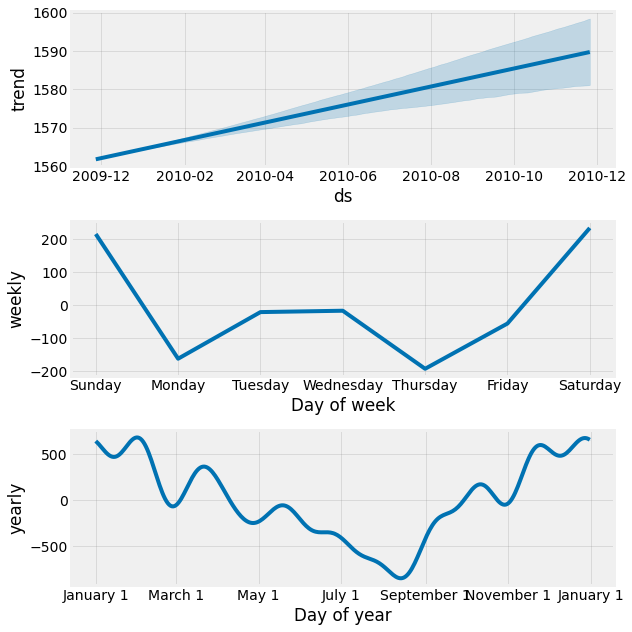

In [40]:
#model components
fig = model.plot_components(forecast)

## Multivariate

In [41]:
#create mapping for the new column names
column_name = {'Global_reactive_power': 'add1', 'Voltage': 'add2', 'Global_intensity': 'add3', 
               'Sub_metering_1': 'add4', 'Sub_metering_2': 'add5', 'Sub_metering_3': 'add6'}

In [42]:
df_daily_multi = df_daily.rename(columns=column_name)
df_daily_multi.head()

,Global_active_power,add1,add2,add3,add4,add5,add6
Datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [43]:
train_multi = df_daily_multi[:-365]
test_multi = df_daily_multi[-365:]

In [44]:
df_daily_multi.columns

Index(['Global_active_power', 'add1', 'add2', 'add3', 'add4', 'add5', 'add6'], dtype='object')

In [45]:
add = ['add1', 'add2', 'add3', 'add4', 'add5', 'add6']

In [46]:
for col in add:
    train[col] = train_multi[col].values
train.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [47]:
model2 = Prophet()

for col in add:
    model2.add_regressor(col)
    
model2.fit(train)

In [48]:
test_multi.head()

,Global_active_power,add1,add2,add3,add4,add5,add6
Datetime,,,,,,,
2009-11-27,1380.026,133.052,348276.70,5704.0,0.0,396.0,11599.0
2009-11-28,1858.950,225.218,347898.89,7784.8,3199.0,386.0,14350.0
2009-11-29,1650.962,191.056,350364.56,6878.4,1073.0,3061.0,7828.0
2009-11-30,1745.190,153.382,351020.60,7232.2,1080.0,361.0,12039.0
2009-12-01,1756.378,141.874,349391.74,7312.8,0.0,354.0,10821.0


In [49]:
# creating the test dataframe 
test_multi2 = test_multi.reset_index().rename(columns={'Datetime': 'ds'}).drop('Global_active_power', axis=1)
test_multi2.head()

,ds,add1,add2,add3,add4,add5,add6
0,2009-11-27,133.052,348276.70,5704.0,0.0,396.0,11599.0
1,2009-11-28,225.218,347898.89,7784.8,3199.0,386.0,14350.0
2,2009-11-29,191.056,350364.56,6878.4,1073.0,3061.0,7828.0
3,2009-11-30,153.382,351020.60,7232.2,1080.0,361.0,12039.0
4,2009-12-01,141.874,349391.74,7312.8,0.0,354.0,10821.0


In [50]:
forecast2 = model2.predict(test_multi2) # forecasts the test data

In [51]:
forecast2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1587.299935,1364.933078,1397.403705,1587.299935,1587.299935,7.085885,7.085885,7.085885,-0.040338,...,0.015671,0.015671,0.015671,3.644206,3.644206,3.644206,0.0,0.0,0.0,1381.226334
1,2009-11-28,1587.416379,1845.049506,1878.164740,1587.416379,1587.416379,-8.707770,-8.707770,-8.707770,-0.036526,...,0.802212,0.802212,0.802212,3.948558,3.948558,3.948558,0.0,0.0,0.0,1861.701539
2,2009-11-29,1587.532824,1628.696142,1660.709424,1587.532824,1587.532824,-2.853736,-2.853736,-2.853736,-0.061400,...,0.160314,0.160314,0.160314,4.287811,4.287811,4.287811,0.0,0.0,0.0,1643.888294
3,2009-11-30,1587.649268,1725.554894,1756.703052,1587.649268,1587.649268,3.602117,3.602117,3.602117,-0.068019,...,-0.205931,-0.205931,-0.205931,4.668448,4.668448,4.668448,0.0,0.0,0.0,1741.977737
4,2009-12-01,1587.765712,1746.325864,1777.489763,1587.765712,1587.765712,5.574139,5.574139,5.574139,-0.051586,...,-1.538868,-1.538868,-1.538868,5.096202,5.096202,5.096202,0.0,0.0,0.0,1762.136181


In [52]:
mean_absolute_percentage_error(test_multi['Global_active_power'], 
                               forecast2['yhat'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


inf

In [54]:
mse = mean_squared_error(test_multi['Global_active_power'], 
                               forecast2['yhat'])
rmse = mse**(1/2)
rmse

38.3234865764227

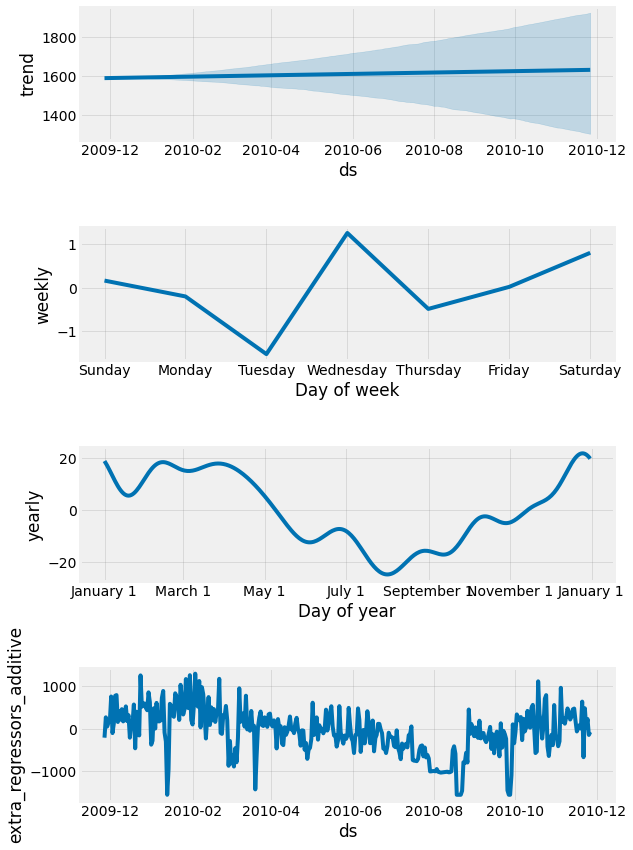

In [53]:
fig = model2.plot_components(forecast2)